1. Look at the dataset
    - Different sizes of images
    - Samples with wrong labels
    - Different backgrounds
    - File formats
    - Intensity range
    - Class distribution
2. Pre-process the data
    - Padded the images so they are square
    - Resized the images to a managable size
3. Experimental setup
    -   Single train/val/test split: 70%/ 15%/ 15%
    -   Set data augmentation
    -   Create data loaders
4. Transfer learning
    - SOTA models on imagenet
    - Add and train new top/predictor
    - Fine-tune all or some feature learning layers 
5. Loss and metrics
    -   Loss: categorical cross-entropy
    -   Metrics: Accuracy, sensitivity, specificity, confusion matrix, training and inference time?
6. Set your callbacks and track your experiments
    - Early stopping - patience
    - Model check point
    - Learning rate scheduler
    - Weights and biases (train/val loss)
7. Set your main hyperparameters
    - batch size
    - learning rate
    - number of epochs
8. Train 
    - Train your model
    - Need to write your training code in pure Python and PyTorch or use another library like lightning or ignite
9. Test 
    - Run prediction on your test set
    - Extract relevant metrics
    - Measure inference time

- Other suggestions:
    - Use config files to make experimenting different configs easily
    - Design locally, but run experiments in the cluster



In [1]:
import torch
import glob
import matplotlib.pylab as plt
from torch.utils.data import Dataset
import torch.nn as nn
import numpy as np
from PIL import Image
from torchvision.models import resnet18
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Check if GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, StepLR

cuda:0


In [2]:
TRAIN_PATH = r"D:\UCalgary\ENEL645\A2\garbage_data\garbage_data\CVPR_2024_dataset_Train"
VAL_PATH = r"D:\UCalgary\ENEL645\A2\garbage_data\garbage_data\CVPR_2024_dataset_Val"
TEST_PATH = r"D:\UCalgary\ENEL645\A2\garbage_data\garbage_data\CVPR_2024_dataset_Test"

In [3]:
# Transforms 
torchvision_transform_train = transforms.Compose([transforms.Resize((224,224)),\
    transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(), transforms.RandomRotation(15),
    transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406] ,std=[0.229, 0.224, 0.225] )])

torchvision_transform_val_test = transforms.Compose([transforms.Resize((224,224)),\
    transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406] ,std=[0.229, 0.224, 0.225] )])

# Load datasets
train_dataset = ImageFolder(root=TRAIN_PATH, transform= torchvision_transform_train)
val_dataset = ImageFolder(root=VAL_PATH, transform= torchvision_transform_val_test)
test_dataset = ImageFolder(root=TEST_PATH, transform= torchvision_transform_val_test)

# Define batch size and number of workers (adjust as needed)
batch_size = 32
num_workers = 4

# Create data loaders
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [4]:
class_names = train_dataset.classes
print(class_names)
print("Train set:", len(trainloader)*batch_size)
print("Val set:", len(valloader)*batch_size)
print("Test set:", len(testloader)*batch_size)

['Black', 'Blue', 'Green', 'TTR']
Train set: 10208
Val set: 1824
Test set: 3456


In [5]:
train_iterator = iter(trainloader)
train_batch = next(train_iterator)

In [6]:
print(train_batch[0].size())
print(train_batch[1].size())

torch.Size([32, 3, 224, 224])
torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.3755459].


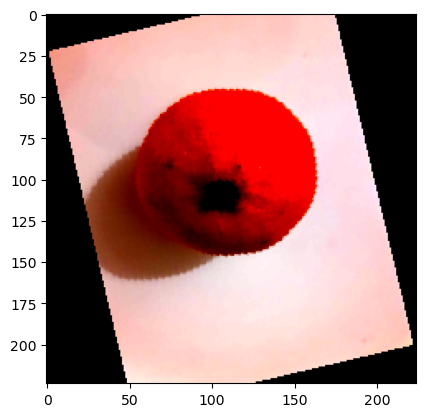

In [7]:
plt.figure()
plt.imshow(train_batch[0].numpy()[16].transpose(1,2,0))
plt.show()

In [8]:
class GarbageModel(nn.Module):
    def __init__(self,  num_classes, input_shape, transfer=False):
        super().__init__()

        self.transfer = transfer
        self.num_classes = num_classes
        self.input_shape = input_shape
        
        # transfer learning if weights=True
        self.feature_extractor = models.resnet18(weights=transfer)

        if self.transfer:
            # layers are frozen by using eval()
            #self.feature_extractor.eval()
            
            # freeze all layers first
            for param in self.feature_extractor.parameters():
                param.requires_grad = False
            # unfreeze the last block and fc layer
            for param in self.feature_extractor.layer4.parameters():
                param.requires_grad = True
            for param in self.feature_extractor.fc.parameters():
                param.requires_grad = True

        n_features = self.feature_extractor.fc.in_features
        self.feature_extractor.fc = nn.Linear(n_features, num_classes)
        for param in self.feature_extractor.fc.parameters():
            param.requires_grad = True
        #n_features = self._get_conv_output(self.input_shape)
        #self.classifier = nn.Linear(n_features, num_classes)

    def _get_conv_output(self, shape):
        batch_size = 1
        tmp_input = torch.autograd.Variable(torch.rand(batch_size, *shape))

        output_feat = self.feature_extractor(tmp_input) 
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size

    # will be used during inference
    def forward(self, x):
       x = self.feature_extractor(x)
       #x = x.view(x.size(0), -1)
       #x = self.classifier(x)
       
       return x


In [9]:
net = GarbageModel(4, (3,224,224), True)
net.to(device)

D:\softwares\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


GarbageModel(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [10]:
criterion = nn.CrossEntropyLoss() # Loss function
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, net.parameters()), lr=1e-4)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
#optimizer = torch.optim.AdamW(net.parameters(), lr = 0.001)
#scheduler = ExponentialLR(optimizer, gamma=0.9)

In [11]:
nepochs = 20
PATH = './garbage_net.pth' # Path to save the best model
early_stopping_wait = 3 # Number of epochs to wait before stopping
epochs_no_improve = 0

best_loss = 1e+20
for epoch in range(nepochs):  # loop over the dataset multiple times
    net.train()
    # Training Loop
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
    print(f'{epoch + 1},  train loss: {train_loss / i:.3f},', end = ' ')
    #scheduler.step()
    
    net.eval()
    val_loss = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        print(f'val loss: {val_loss / i:.3f}')
        
        # Save best model
        if val_loss < best_loss:
            print("Saving model")
            epochs_no_improve = 0
            torch.save(net.state_dict(), PATH)
            best_loss = val_loss
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve == early_stopping_wait:
            print('Early Stopping')
            break
    
    scheduler.step(val_loss)
        
print('Finished Training')

1,  train loss: 0.748, val loss: 0.679
Saving model
2,  train loss: 0.587, val loss: 0.634
Saving model
3,  train loss: 0.505, val loss: 0.649
4,  train loss: 0.441, val loss: 0.634
Saving model
5,  train loss: 0.384, val loss: 0.657
6,  train loss: 0.336, val loss: 0.640
7,  train loss: 0.300, val loss: 0.689
Early Stopping
Finished Training


In [14]:
# Load the best model to be used in the test set
net = GarbageModel(4, (3,224,224), transfer=True)
net.load_state_dict(torch.load(PATH, weights_only=True))
#net.load_state_dict(torch.load(PATH))
net.to(device)
net.eval()

GarbageModel(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [15]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total} %')

Accuracy of the network on the test images: 67.76450014573011 %


In [16]:
print(total)

3431
